In [3]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from scipy.linalg import svd, expm
import time

In [4]:
# Define functions

def syssim(M, N, dim_lat, nu):
    Z = np.zeros((dim_lat + nu, N))
    #rho = 5  # Increasing rho increases excitation for better operator recovery
    #Sigma = rho * np.eye(dim_lat + nu) + np.random.rand(dim_lat + nu, dim_lat + nu)
    #Sigma_symm = ((1 / 2) * (Sigma + Sigma.T))
    #Sigma_symm = ((dim_lat + nu) / np.trace(Sigma_symm)) * Sigma_symm
    Sigma_symm = np.eye(dim_lat + nu)
    for i in range(N):
        Z[:, i] = sqrtm(Sigma_symm).dot(np.random.normal(0, 1, dim_lat + nu))

    w = np.random.normal(0, 1, dim_lat)
    Y = M.dot(Z) + w.reshape(-1, 1)

    return Z, Y


def subspace_distance(Phi_1, Phi_2):
    r = Phi_1.shape[0]
    distance = np.sqrt(r - np.linalg.norm(Phi_1.dot(Phi_2.T), 'fro') ** 2)
    return distance


def tasksgen(nx, nu, r, dim_lat, H, scale):
    # True representation
    Phi, _, _ = svd(np.random.randn(dim_lat + nu, dim_lat + nu))
    Phi = Phi[:r, :]

    F_0 = np.random.randn(dim_lat, nu + nx)  # Nominal task weights F
    M_0 = F_0.dot(Phi)  # Nominal operator M

    # Generating different tasks weights
    F = []
    P = []
    for h in range(1, H + 1):
        L = scale * np.random.randn(dim_lat, dim_lat)
        skewL = (L - L.T) / 2
        P.append(expm(skewL))
        F.append(P[h - 1].dot(F_0))  # Generating the true weights for H different tasks

    M = []
    for h in range(H):
        M.append(F[h].dot(Phi))  # Generating the true operators M for H different tasks
    return M, Phi

def feature_whitened_alt_descent(Phi_hat, K, eta, H, M, Phi_true, nx, nu, N, dim_lat):
    F = [np.zeros((nx + nu, dim_lat + nu)) for _ in range(H)]
    Phi = [Phi_hat.copy() for _ in range(H)]
    Error_rep = np.zeros(K)

    for k in range(K):
        start_time = time.time()
        # Calculating subspace distance
        Error_rep[k] = subspace_distance(Phi_true, Phi_hat)
        

        # Initializing all the tasks with the same representation
        for h in range(H):
            Phi[h] = Phi_hat.copy()

        for h in range(H):
            # Sample a fresh data-set
            Z1, Y1 = syssim(M[h], N, dim_lat, nu)
            Z2, _ = syssim(M[h], N, dim_lat, nu)
            Z3, Y3 = syssim(M[h], N, dim_lat, nu)

            cov_sum = Z2.dot(Z2.T)

            # Computing Grad_Phi
            inv_term = np.linalg.inv(Phi[h].dot(Z1.dot(Z1.T)).dot(Phi[h].T))
            F[h] = Y1.dot(Z1.T).dot(Phi[h].T).dot(inv_term)
            Grad_Phi = (F[h].T.dot(F[h]).dot(Phi[h]).dot(Z3.dot(Z3.T)) - F[h].T.dot(Y3).dot(Z3.T)).dot(np.linalg.inv(cov_sum))
            Phi[h] -= eta * Grad_Phi

        # Aggregation
        Phi_avg = np.zeros((nx + nu, dim_lat + nu))
        for h in range(H):
            Phi_avg += (1 / H) * Phi[h]

        Q,R = np.linalg.qr(Phi_avg.T, mode='reduced')
        Phi_hat = Q.T
        
        end_time = time.time()
        print(f"Iteration: {k}, Error: {Error_rep[k]}, Time: {end_time - start_time}")
        
    return Error_rep


def alt_descent(Phi_hat, K, eta, H, M, Phi_true, nx, nu, N, dim_lat):
    F = [np.zeros((nx + nu, dim_lat + nu)) for _ in range(H)]
    Phi = [Phi_hat.copy() for _ in range(H)]
    Error_rep = np.zeros(K)

    for k in range(K):
        start_time = time.time()
        # Calculating subspace distance
        Error_rep[k] = subspace_distance(Phi_true, Phi_hat)

        # Initializing all the tasks with the same representation
        for h in range(H):
            Phi[h] = Phi_hat.copy()

        for h in range(H):
            # Sample a fresh data-set
            Z, Y = syssim(M[h], N, dim_lat, nu)

            # Computing F and Grad_Phi
            inv_term = np.linalg.inv(Phi[h].dot(Z.dot(Z.T)).dot(Phi[h].T))
            F[h] = Y.dot(Z.T).dot(Phi[h].T).dot(inv_term)
            Grad_Phi = (F[h].T.dot(F[h]).dot(Phi[h]).dot(Z.dot(Z.T)) - F[h].T.dot(Y).dot(Z.T))

            Phi[h] -= eta * Grad_Phi

        # Aggregation
        Phi_avg = np.zeros((nx + nu, dim_lat + nu))
        for h in range(H):
            Phi_avg += (1 / H) * Phi[h]

        Q,R = np.linalg.qr(Phi_avg.T, mode='reduced')
        Phi_hat = Q.T
        end_time = time.time()
        print(f"Iteration: {k}, Error: {Error_rep[k]}, Time: {end_time - start_time}")
    return Error_rep

$\textbf{System Parameter:}$

In [16]:
# System dimensions
nx = 5
nu = 2
r = nx + nu  # rank
dim_lat = 50  # dimension of the latent space
H = 10  # number of tasks
scale = 0.001  # scale of rotation

M, Phi_true = tasksgen(nx, nu, r, dim_lat, H, scale)

np.save('seed', {"M_list": M, "Phi_true": Phi_true})

nr = 1  # Number of systems realizations
K = 100  # number of global iterations
Error_r = []
N = 100  # number of samples

#eta = 0.0075  # step-size
eta = 0.003  # step-size

$\textbf{De-biasing and Feature Whitening:}$

In [17]:
L = np.random.randn(dim_lat + nu, dim_lat + nu)
skewL = (L - L.T) / 2
rot = expm(skewL)
Phi_hat = Phi_true.dot(rot)
Error_FW = feature_whitened_alt_descent(Phi_hat, K, eta, H, M, Phi_true, nx, nu, N, dim_lat)

Iteration: 0, Error: 2.4248929743767773, Time: 0.7539091110229492
Iteration: 1, Error: 2.2892017088949634, Time: 0.7674417495727539
Iteration: 2, Error: 2.116010059497368, Time: 0.7730200290679932
Iteration: 3, Error: 1.951798101469685, Time: 0.9447996616363525
Iteration: 4, Error: 1.7980309208724106, Time: 0.8798384666442871
Iteration: 5, Error: 1.6562945271822878, Time: 0.852597713470459
Iteration: 6, Error: 1.5392310175958503, Time: 0.8836417198181152
Iteration: 7, Error: 1.434599558396547, Time: 0.8797922134399414
Iteration: 8, Error: 1.3451298647993133, Time: 0.9651215076446533
Iteration: 9, Error: 1.264504299897415, Time: 0.9809091091156006
Iteration: 10, Error: 1.1834715331878904, Time: 0.8871309757232666
Iteration: 11, Error: 1.093766369930856, Time: 0.9249517917633057
Iteration: 12, Error: 1.0007554790985689, Time: 0.8421320915222168
Iteration: 13, Error: 0.9065865748781077, Time: 1.120267629623413
Iteration: 14, Error: 0.801181740000043, Time: 1.0409777164459229
Iteration: 15

$\textbf{Alternating Descent Minimization:}$

In [18]:
Error_WFW = np.zeros((nr, K))
H = 10
Error_WFW = alt_descent(Phi_hat, K, eta/100, H, M, Phi_true, nx, nu, N, dim_lat)

Iteration: 0, Error: 2.4248929743767773, Time: 0.27027344703674316
Iteration: 1, Error: 2.3729932662379594, Time: 0.26628780364990234
Iteration: 2, Error: 2.3103841608262448, Time: 0.24634146690368652
Iteration: 3, Error: 2.2329243078370227, Time: 0.26130151748657227
Iteration: 4, Error: 2.1558713966612713, Time: 0.24634099006652832
Iteration: 5, Error: 2.0740796256732605, Time: 0.24933266639709473
Iteration: 6, Error: 1.9981656018169864, Time: 0.25830793380737305
Iteration: 7, Error: 1.922784765515055, Time: 0.2732694149017334
Iteration: 8, Error: 1.853755016955364, Time: 0.2449021339416504
Iteration: 9, Error: 1.7851205358609346, Time: 0.2573115825653076
Iteration: 10, Error: 1.7206928850973793, Time: 0.23836278915405273
Iteration: 11, Error: 1.660668472206503, Time: 0.25033044815063477
Iteration: 12, Error: 1.610348473395647, Time: 0.25531625747680664
Iteration: 13, Error: 1.5630769323978146, Time: 0.2453451156616211
Iteration: 14, Error: 1.521765601437865, Time: 0.24434542655944824

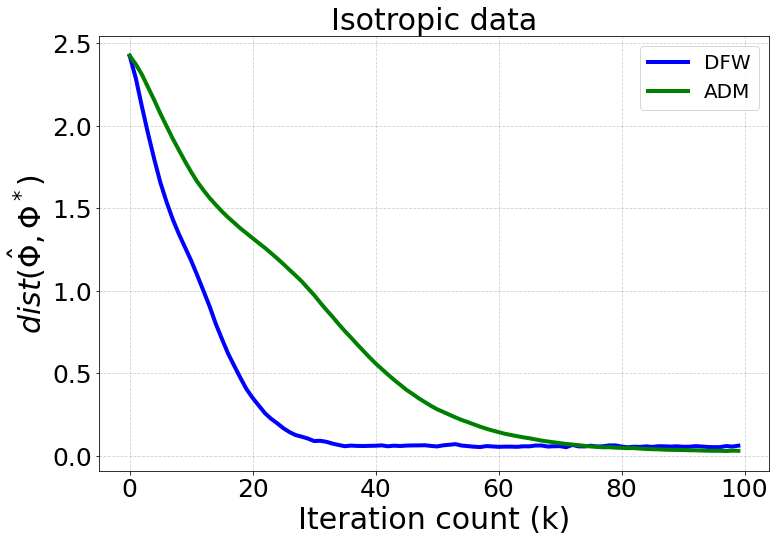

In [19]:
# Create a plot to show the convergence of the Gibbs Sampler (Log-joint vs iterations)
fig, ax = plt.subplots(figsize=(12,8))


# Plot the data
ax.plot(list(range(int(K))), Error_FW, label=r'DFW', color='blue', linestyle='-', linewidth=4)
ax.plot(list(range(int(K))), Error_WFW, label=r'ADM',  color='green', linestyle='-', linewidth=4)

# Set labels and a title
ax.set_xlabel('Iteration count (k)',fontsize=30)
ax.set_ylabel(r'$dist(\hat{\Phi},\Phi^*)$',fontsize=30)
ax.tick_params(axis='both', labelsize=25)
ax.set_title(r'Isotropic data',fontsize=30)
plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:2]  
labels = labels[:2] 
plt.legend(handles=handles, labels=labels,fontsize=20)

# Customize the grid
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()